In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from behavioral_cloning import *
from load_policy import load_policy


 # DAGGER

In [23]:
batch_size = 32
expert_rollout = 20
dagger_rollout = 20
max_timesteps = 0 #0 means run until termination
use_expert_cache = True
store=False
training_epochs = 1
losses = []

from IPython.display import display, clear_output
import matplotlib.pyplot as plt

tf.reset_default_graph()
losses = []

it_dagger = 10
#ax = f.subplot(111)
#tasks = ['Hopper-v2', 'Ant-v2', 'HalfCheetah-v2', 'Humanoid-v2', 'Reacher-v2','Walker2d-v2']
tasks = ['Hopper-v2']
results = pd.DataFrame(columns=[])
for task in tasks:
    tf.reset_default_graph()
    with tf.Session() as sess:
        expert_policy = load_policy('./experts/{}.pkl'.format(task))
        if use_expert_cache:
            dataset, expert_returns = get_dataset('./expert_data/{}-{}.pkl'.format(task,expert_rollout))
        else:
            dataset, expert_returns = get_dataset(envname=task,render=False,expert_policy_file='experts/'+task+'.pkl',max_timesteps=0,num_rollouts=expert_rollout,store=store)
        dataset = dataset.map(lambda x, y: (tf.cast(x,tf.float32),y))
        obs_dim = dataset.output_shapes[0].as_list()
        action_dim = dataset.output_shapes[1].as_list()[1:]
        dataset = dataset.repeat(training_epochs)
        batched_dataset = dataset.batch(batch_size)
        iterator = batched_dataset.make_one_shot_iterator()
        next_element = iterator.get_next()
        behavioral_net = BehavioralCloningNet(obs_dim, action_dim, batch_size,learning_rate=0.01)
        losses = []
        returns = []
        evaluate = EvaluateDagger(task,expert_policy,behavioral_net,render=False)
        for i in range(it_dagger):
            #print("dagger it {}".format(i))
            losses += behavioral_net.train(next_element)
            evaluate.expert_obs = []
            evaluate.expert_actions = []
            return_ = evaluate.evaluate(rollouts=dagger_rollout)
            print("dagger it {}, mean return {}".format(i,np.mean(return_)))
            returns.append(return_)
            expert_obs_arr = np.asarray(evaluate.expert_obs,dtype=np.float32)
            expert_actions_arr = np.asarray(evaluate.expert_actions,dtype=np.float32)
            expert_labeled_new_data = tf.data.Dataset.from_tensor_slices((expert_obs_arr,expert_actions_arr))
            dataset = dataset.concatenate(expert_labeled_new_data)
            dataset = dataset.shuffle(buffer_size=10000)
            dataset = dataset.take(1000000)
            batched_dataset = dataset.batch(batch_size,True)
            iterator = batched_dataset.make_one_shot_iterator()
            next_element = iterator.get_next()
            #dagger_rollout = int(dagger_rollout * 1.1)
            #fig = plt.figure()
            #plt.plot(losses)
            #plt.xlabel('Batch')
            #plt.ylabel('Loss (mean square)')
            #plt.legend(['Train loss {}'.format(task)],loc='upper center')
            #plt.show(fig)
            results = results.append({'Task': task,
                                'mean return': np.mean(return_),
                                'std return': np.std(return_),
                                'expert mean return': np.mean(expert_returns),
                                'expert std return': np.std(expert_returns),
                                'expert rollouts': expert_rollout,
                                'training epochs': training_epochs,
                                'dagger its': i},
                                ignore_index=True)
results.to_csv('results_dagger.csv')



obs (1, 11) (1, 11)
dagger it 0, mean return 736.0769779547579
dagger it 1, mean return 830.7500919300234
dagger it 2, mean return 874.0364912999794
dagger it 3, mean return 3580.920743705319
dagger it 4, mean return 1317.9380580686814
dagger it 5, mean return 1334.4896558361386
dagger it 6, mean return 3101.087675328911
dagger it 7, mean return 3497.9828368728427
dagger it 8, mean return 3771.0546427939344
dagger it 9, mean return 3621.78699838433


In [24]:
results

,Task,dagger its,expert mean return,expert rollouts,expert std return,mean return,std return,training epochs
0,Hopper-v2,0.0,3777.774247,20.0,3.781346,736.076978,140.874144,1.0
1,Hopper-v2,1.0,3777.774247,20.0,3.781346,830.750092,11.900246,1.0
2,Hopper-v2,2.0,3777.774247,20.0,3.781346,874.036491,29.116930,1.0
3,Hopper-v2,3.0,3777.774247,20.0,3.781346,3580.920744,409.126532,1.0
4,Hopper-v2,4.0,3777.774247,20.0,3.781346,1317.938058,158.465258,1.0
5,Hopper-v2,5.0,3777.774247,20.0,3.781346,1334.489656,93.922257,1.0
6,Hopper-v2,6.0,3777.774247,20.0,3.781346,3101.087675,818.421294,1.0
7,Hopper-v2,7.0,3777.774247,20.0,3.781346,3497.982837,108.998711,1.0
8,Hopper-v2,8.0,3777.774247,20.0,3.781346,3771.054643,18.861343,1.0
9,Hopper-v2,9.0,3777.774247,20.0,3.781346,3621.786998,47.290750,1.0


<IPython.core.display.Javascript object>


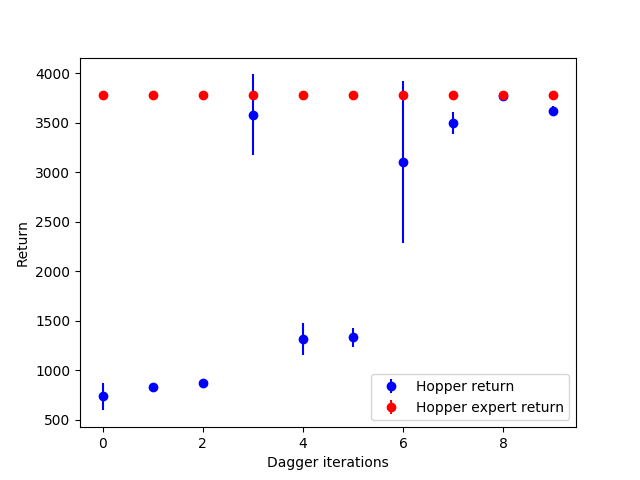

In [26]:
fig = plt.figure()
hopper_data = results[results['Task']=='Hopper-v2']
#ant_data = results[results['Task']=='Ant-v2']
dagger_its = hopper_data['dagger its'].values
plt.errorbar(dagger_its,hopper_data['mean return'].values,yerr=[hopper_data['std return'], hopper_data['std return'],], c='blue',fmt='o')
plt.errorbar(dagger_its,hopper_data['expert mean return'].values,yerr=[hopper_data['expert std return'], hopper_data['expert std return'],], c='red',fmt='o')
plt.xlabel("Dagger iterations")
plt.ylabel("Return")
#plt.plot(epochs,hopper_data['mean return'].values,c='red')
#plt.plot(epochs,hopper_data['expert mean return'].values,c='blue')
#plt.plot(epochs,ant_data['mean return'].values,c='yellow')
#plt.plot(epochs,ant_data['expert mean return'].values,c='green')
plt.legend(['Hopper return','Hopper expert return'])
plt.show(fig)